In [1]:
import sys
from pathlib import Path

parent_dir = str(Path().absolute().parent)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# sns.set_context("paper")
sns.set_theme(
    style='ticks', 
    rc={
    "text.usetex": False,
    "font.family": "serif",
    "axes.grid": True,
    "lines.linewidth": 0.8,
    'axes.linewidth':0.8,
    'grid.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3.0,
    'ytick.major.size': 3.0,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.edgecolor": "black"
    },
    palette='deep',
    )
sns.set_palette('Set2')


In [3]:
from src.utils import find_root


BASE_PATH = find_root()
DATASET_TAG = 'adult'
SENSITIVE_FEAT = 'sex'
knows = ['med']
clfs = ['GB_no_sensitive', 'RF_no_sensitive', 'LR_no_sensitive', 'FAIRGBM']

interventions = ['Female_to_Male', 'Male_to_Female']
cf_metrics = ['negative_to_positive_switch_rate', 'positive_to_negative_switch_rate']
metrics = [f'{i}.{m}' for i in interventions for m in cf_metrics]

## 1. Graph uncertainty

In [4]:
from src.causality.causal_world import  inspect_graph_uncertainty
cws_by_know = {}
for know in knows:
    fpath = BASE_PATH / 'output' / DATASET_TAG / know / 'causal_worlds.pkl'
    with open(fpath, 'rb') as f:
        cws_by_know[know] = pickle.load(f)

/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# # low knowledge
# cws = cws_by_know['low']
# print(inspect_graph_uncertainty(cws, SENSITIVE_FEAT))

In [7]:
# medium knowledge
# cws = cws_by_know['med']
# print(inspect_graph_uncertainty(cws, SENSITIVE_FEAT))

## 2. Feature variance

In [8]:
# feat_var_by_know = {}
# for know in knows:
#     fpath = BASE_PATH / 'output' / DATASET_TAG / know / 'counterfactuals_summary' / 'feat_var_by_individual.csv'
#     feat_var_by_know[know] = pd.read_csv(fpath)

In [9]:
# print('Feature var, low knowledge:')
# feat_var_by_know['low']

In [10]:
# print('Feature var, med knowledge:')
# feat_var_by_know['med']

## 3. Score variance

In [11]:
from notebooks.notebook_utils import load_score_variance_data


load_score_variance_data(BASE_PATH, DATASET_TAG, knows, clfs)

,individual,score_variance_by_individual,classifier,knowledge
0,1,0.000000,GB,High
1,13,0.000000,GB,High
2,24,0.001062,GB,High
3,27,0.000001,GB,High
4,36,0.003184,GB,High
...,...,...,...,...
39071,48821,0.008213,FAIRGBM,High
39072,48823,0.000005,FAIRGBM,High
39073,48827,0.001644,FAIRGBM,High
39074,48835,0.000029,FAIRGBM,High


In [12]:
from notebooks.notebook_utils import load_score_variance_data
from src.plot.bar_charts import plot_score_variance


df_score_var = load_score_variance_data(BASE_PATH, DATASET_TAG, knows, clfs)
df_score_var

,individual,score_variance_by_individual,classifier,knowledge
0,1,0.000000,GB,High
1,13,0.000000,GB,High
2,24,0.001062,GB,High
3,27,0.000001,GB,High
4,36,0.003184,GB,High
...,...,...,...,...
39071,48821,0.008213,FAIRGBM,High
39072,48823,0.000005,FAIRGBM,High
39073,48827,0.001644,FAIRGBM,High
39074,48835,0.000029,FAIRGBM,High


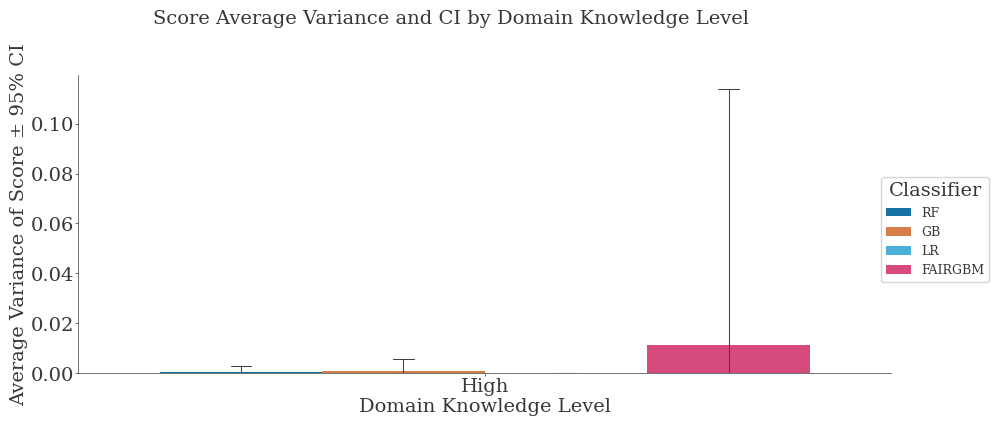

In [13]:
g = plot_score_variance(df_score_var, './adult_charts/adult_score_variance.pdf',)

## 4. CF metrics variance

In [35]:
from notebooks.notebook_utils import load_and_tidy_fairness_metrics
from src.plot.bar_charts import plot_counterfactual_metrics


df = load_and_tidy_fairness_metrics(BASE_PATH, DATASET_TAG, knows, clfs)
df

,Classifier,Knowledge,Rate,intervention,metric
0,GB,High,0.008604,Female_to_Male,PSR
1,GB,High,0.008273,Female_to_Male,PSR
2,GB,High,0.009265,Female_to_Male,PSR
3,GB,High,0.010258,Female_to_Male,PSR
4,GB,High,0.009265,Female_to_Male,PSR
...,...,...,...,...,...
523,FAIRGBM,High,0.232774,Male_to_Female,NSR
524,FAIRGBM,High,0.251882,Male_to_Female,NSR
525,FAIRGBM,High,0.249566,Male_to_Female,NSR
526,FAIRGBM,High,0.248408,Male_to_Female,NSR


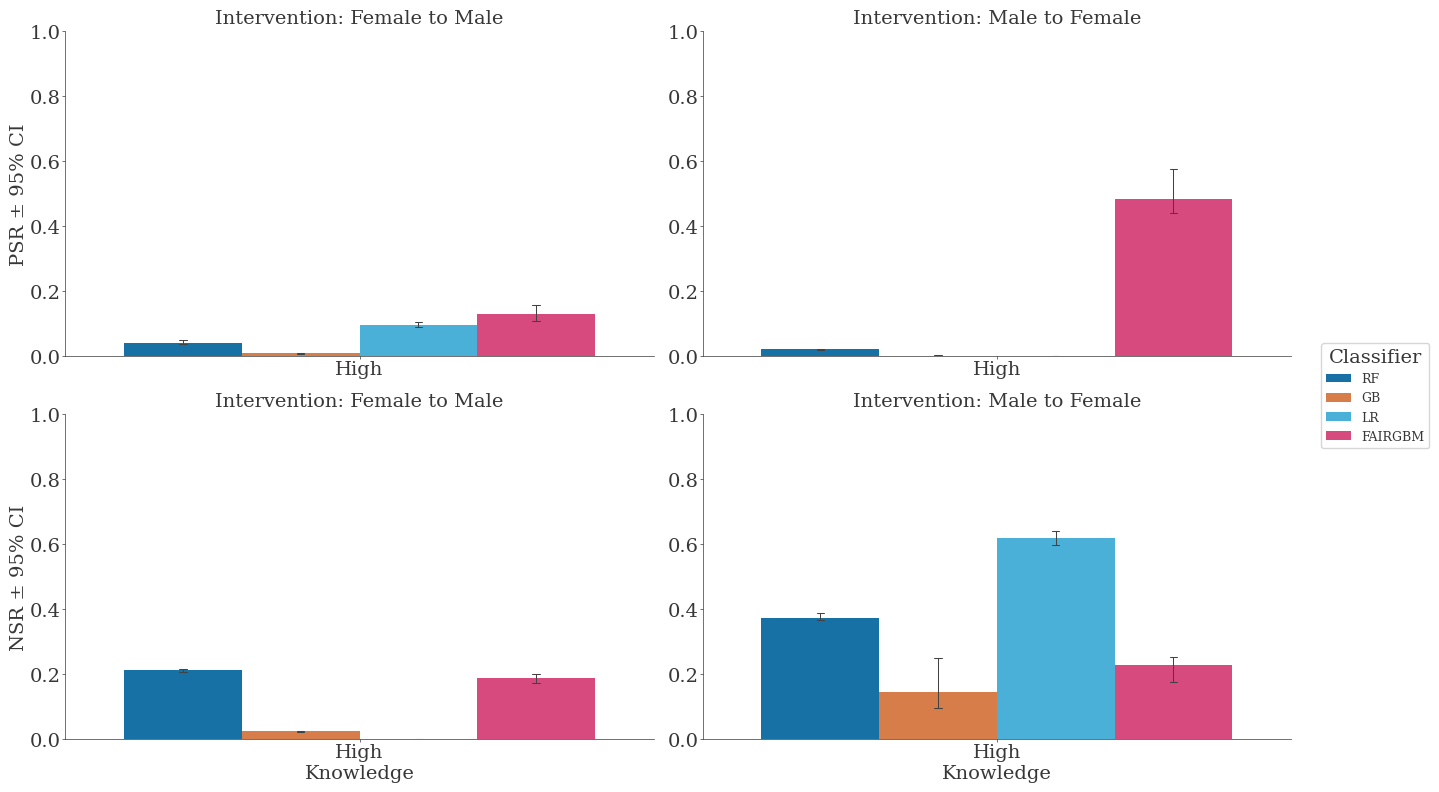

In [15]:

g = plot_counterfactual_metrics(df, interventions, 'adult_charts/adult_cf.pdf')
plt.show()


In [16]:
summary_df = (
    df.groupby(['Knowledge', 'intervention', 'metric', 'Classifier'])['Rate']
      .agg(mean_rate='mean',
           ci_low=lambda s: np.percentile(s, 2.5),   # 2.5 th percentile
           ci_high=lambda s: np.percentile(s, 97.5)) # 97.5 th percentile
      .reset_index()
)
summary_df.round(4).to_clipboard(sep=';')

## 6. FAIRGBM Analysis

Let's analyze the FAIRGBM results in detail to understand how different fairness constraints affect counterfactual fairness.


## 5. Counterfactuals quality

In [17]:
fpath = '/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/output/adult/med/mw_counterfactuals.pkl'
with open(fpath, 'rb') as f:
    cf_quality = pickle.load(f)

In [18]:
cf_quality.counterfactuals_quality

,overall_outlier_percent,sbg0_outlier_percent,sbg1_outlier_percent,n_real_0,n_cf_0,density_0,coverage_0,stat_sim_0,n_real_1,n_cf_1,density_1,coverage_1,stat_sim_1,time_evaluate_outliers,time_evaluate_cf_quality
causal_world,,,,,,,,,,,,,,,
0,0.100727,0.078552,0.111828,3259,3259,0.233446,0.730285,0.718970,6510,6510,0.223195,0.559293,0.730283,1.079015,1.796629
1,0.102058,0.074256,0.115975,3259,3259,0.232157,0.730285,0.718836,6510,6510,0.222642,0.558986,0.730283,0.950600,1.650816
2,0.100727,0.077017,0.112596,3259,3259,0.229457,0.730285,0.718958,6510,6510,0.222028,0.558986,0.730283,0.829296,1.746322
3,0.101750,0.082541,0.111367,3259,3259,0.207119,0.687327,0.718278,6510,6510,0.201567,0.519355,0.730283,0.937169,1.594326
4,0.103081,0.077631,0.115822,3259,3259,0.229150,0.730285,0.718985,6510,6510,0.221966,0.558833,0.730283,0.834921,1.697062
5,0.102672,0.077324,0.115361,3259,3259,0.233753,0.730285,0.718985,6510,6510,0.223779,0.559754,0.730283,0.942942,1.736907
6,0.100932,0.077938,0.112442,3259,3259,0.231605,0.730285,0.718970,6510,6510,0.222396,0.558986,0.730283,0.964898,1.758884
7,0.104412,0.082541,0.115361,3259,3259,0.228905,0.730285,0.718999,6510,6510,0.222181,0.559140,0.730283,0.990177,2.213723
8,0.101034,0.072722,0.115207,3259,3259,0.232648,0.730285,0.718970,6510,6510,0.222366,0.559293,0.730283,1.206336,1.846059


In [19]:
# cf_quality_by_know = {}
# for know in knows:
#     fpath = BASE_PATH / 'output' / DATASET_TAG / know / 'counterfactuals_summary' / 'counterfactuals_quality.csv'
#     df = pd.read_csv(fpath)
#     cols = [col for col in df.columns 
#                             if col.endswith('coverage') or col.endswith('density')]
#     df = df[cols]
#     df['avg'] = df.T.mean()
#     df.sort_values(by='avg', ascending=False, inplace=True)
#     cf_quality_by_know[know] = df

In [20]:
# Load and examine counterfactual quality data structure
fpath = BASE_PATH / 'output' / DATASET_TAG / 'med' / 'mw_counterfactuals.pkl'
with open(fpath, 'rb') as f:
    mw_cf = pickle.load(f)

print("Counterfactual quality data structure:")
print(f"Type: {type(mw_cf.counterfactuals_quality)}")
print(f"Shape: {mw_cf.counterfactuals_quality.shape}")
print(f"Columns: {mw_cf.counterfactuals_quality.columns.tolist()}")
print("\nFirst few rows:")
mw_cf.counterfactuals_quality.head()


Counterfactual quality data structure:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (33, 15)
Columns: ['overall_outlier_percent', 'sbg0_outlier_percent', 'sbg1_outlier_percent', 'n_real_0', 'n_cf_0', 'density_0', 'coverage_0', 'stat_sim_0', 'n_real_1', 'n_cf_1', 'density_1', 'coverage_1', 'stat_sim_1', 'time_evaluate_outliers', 'time_evaluate_cf_quality']

First few rows:


,overall_outlier_percent,sbg0_outlier_percent,sbg1_outlier_percent,n_real_0,n_cf_0,density_0,coverage_0,stat_sim_0,n_real_1,n_cf_1,density_1,coverage_1,stat_sim_1,time_evaluate_outliers,time_evaluate_cf_quality
causal_world,,,,,,,,,,,,,,,
0,0.100727,0.078552,0.111828,3259,3259,0.233446,0.730285,0.718970,6510,6510,0.223195,0.559293,0.730283,1.079015,1.796629
1,0.102058,0.074256,0.115975,3259,3259,0.232157,0.730285,0.718836,6510,6510,0.222642,0.558986,0.730283,0.950600,1.650816
2,0.100727,0.077017,0.112596,3259,3259,0.229457,0.730285,0.718958,6510,6510,0.222028,0.558986,0.730283,0.829296,1.746322
3,0.101750,0.082541,0.111367,3259,3259,0.207119,0.687327,0.718278,6510,6510,0.201567,0.519355,0.730283,0.937169,1.594326
4,0.103081,0.077631,0.115822,3259,3259,0.229150,0.730285,0.718985,6510,6510,0.221966,0.558833,0.730283,0.834921,1.697062


In [21]:
# Calculate average density and coverage across both groups
density_cols = ['density_0', 'density_1']
coverage_cols = ['coverage_0', 'coverage_1']

avg_density = mw_cf.counterfactuals_quality[density_cols].mean(axis=1).mean()
avg_coverage = mw_cf.counterfactuals_quality[coverage_cols].mean(axis=1).mean()

print(f"Average density across groups: {avg_density:.4f}")
print(f"Average coverage across groups: {avg_coverage:.4f}")


Average density across groups: 0.2235
Average coverage across groups: 0.6417


In [29]:
mw_cf.counterfactuals_quality['coverage_1'].median()

In [28]:
(mw_cf.counterfactuals_quality['coverage_0']).median()


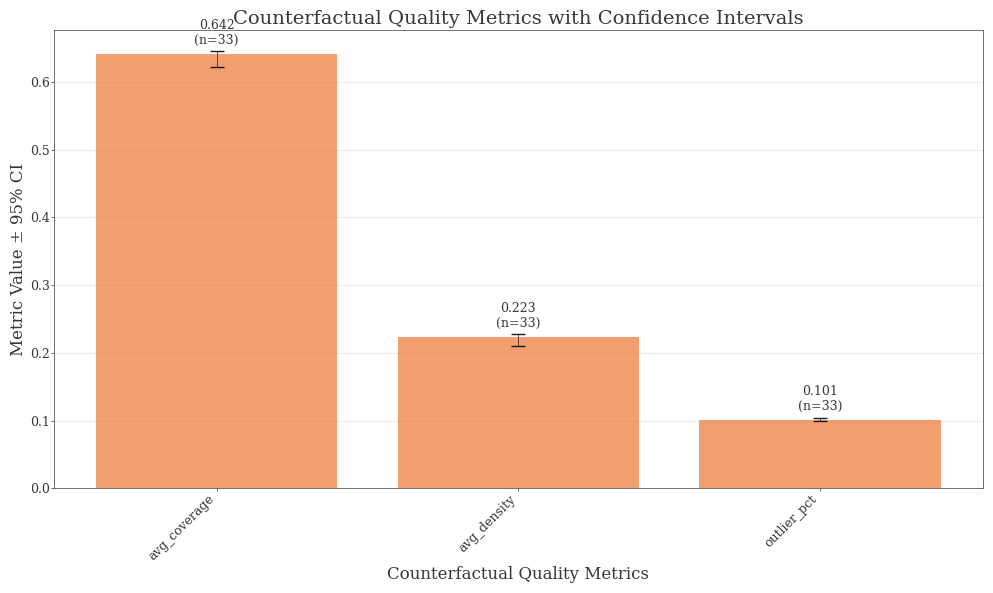

In [32]:
# Plot counterfactual quality with confidence intervals
from src.plot.bar_charts import plot_counterfactual_quality
# Calculate averages across causal worlds
avg_metrics = pd.DataFrame({
    'avg_coverage': (mw_cf.counterfactuals_quality['coverage_0'] + mw_cf.counterfactuals_quality['coverage_1'])/2,
    'avg_density': (mw_cf.counterfactuals_quality['density_0'] + mw_cf.counterfactuals_quality['density_1'])/2,
    'outlier_pct': mw_cf.counterfactuals_quality['overall_outlier_percent']
})

# Create the plot
fig, ax = plot_counterfactual_quality(
    avg_metrics, 
    save_path='./adult_charts/counterfactual_quality_ci.pdf'
)


In [35]:
# # Summary statistics for counterfactual quality metrics
# print("Counterfactual Quality Summary Statistics:")
# print("=" * 50)

# quality_summary = mw_cf.counterfactuals_quality.describe()
# print(quality_summary)

# print("\n" + "=" * 50)
# print("95% Confidence Intervals:")
# print("=" * 50)

# for col in mw_cf.counterfactuals_quality.columns:
#     values = mw_cf.counterfactuals_quality[col].dropna()
#     if len(values) > 0:
#         ci_low = np.percentile(values, 2.5)
#         ci_high = np.percentile(values, 97.5)
#         mean_val = values.mean()
#         print(f"{col:25s}: {mean_val:.4f} [{ci_low:.4f}, {ci_high:.4f}] (n={len(values)})")


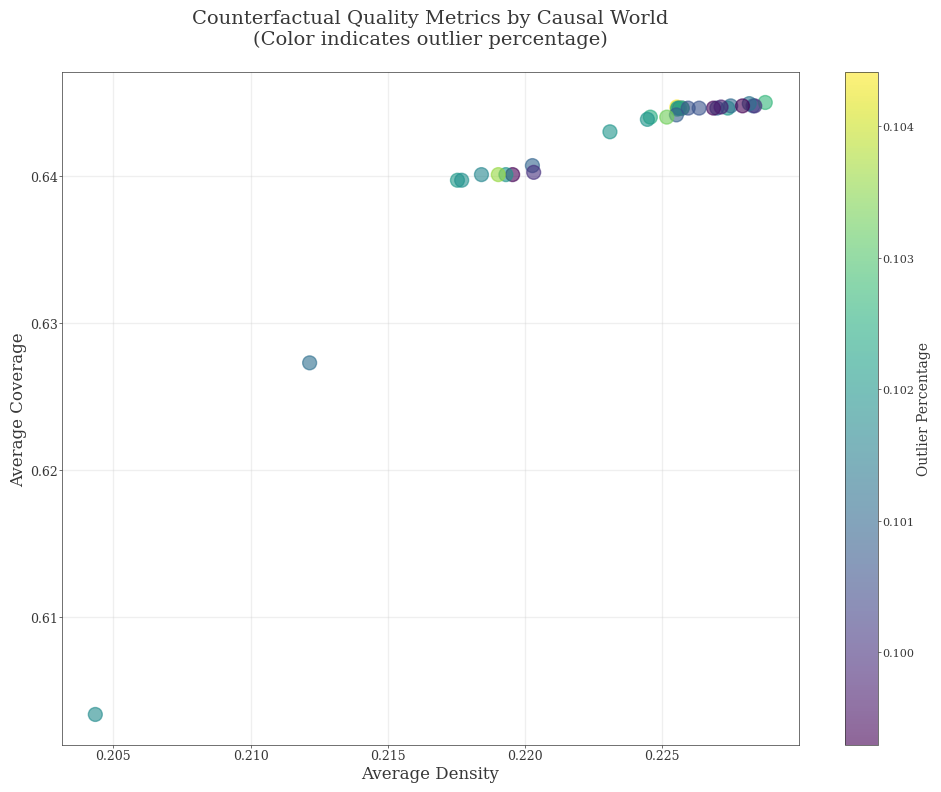

In [ ]:
# Calculate averages across causal worlds
avg_metrics = pd.DataFrame({
    'avg_coverage': (mw_cf.counterfactuals_quality['coverage_0'] + mw_cf.counterfactuals_quality['coverage_1'])/2,
    'avg_density': (mw_cf.counterfactuals_quality['density_0'] + mw_cf.counterfactuals_quality['density_1'])/2,
    'outlier_pct': mw_cf.counterfactuals_quality['overall_outlier_percent']
})

# Create scatter plot
plt.figure(figsize=(10,8))

# Create scatter plot with color indicating outlier percentage
scatter = plt.scatter(avg_metrics['avg_density'], 
                     avg_metrics['avg_coverage'],
                     c=avg_metrics['outlier_pct'],
                     s=100, # Fixed size
                     alpha=0.6,
                     cmap='viridis')

# Add labels and title
plt.xlabel('Average Density', fontsize=12)
plt.ylabel('Average Coverage', fontsize=12)
plt.title('Counterfactual Quality Metrics by Causal World\n(Color indicates outlier percentage)', 
          fontsize=14, pad=20)

# Add grid
plt.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Outlier Percentage', fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()

# Save the plot
plt.savefig('./adult_charts/quality_metrics_scatter.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()


In [31]:
# Calculate average of coverage and density for each causal world
avg_metrics['overall_avg'] = (avg_metrics['avg_coverage'] + avg_metrics['avg_density'])/2

# Find causal world with highest average
best_world = avg_metrics['overall_avg'].idxmax()
best_metrics = avg_metrics.loc[best_world]

print(f"Causal world {best_world} has highest average quality metrics:")
print(f"Average coverage: {best_metrics['avg_coverage']:.3f}")
print(f"Average density: {best_metrics['avg_density']:.3f}") 
print(f"Overall average: {best_metrics['overall_avg']:.3f}")
print(f"Outlier percentage: {best_metrics['outlier_pct']:.3f}")


Causal world 5 has highest average quality metrics:
Average coverage: 0.645
Average density: 0.229
Overall average: 0.437
Outlier percentage: 0.103


## 7. Model Performance and Group Fairness Analysis

Let's analyze the model performance and group fairness metrics acro
ss different classifiers.


In [36]:
# Load model performance and group fairness metrics
from src.plot.bar_charts import load_model_metrics, plot_model_performance, plot_group_fairness

# Load the metrics data
performance_df, fairness_df = load_model_metrics(BASE_PATH, DATASET_TAG, clfs)

print("Model Performance Data:")
print(performance_df.head())
print(f"\nShape: {performance_df.shape}")

print("\nGroup Fairness Data:")
print(fairness_df.head())
print(f"\nShape: {fairness_df.shape}")


Model Performance Data:
        classifier             metric     value
0  GB_no_sensitive           accuracy  0.869587
1  GB_no_sensitive          precision  0.800226
2  GB_no_sensitive             recall  0.606501
3  GB_no_sensitive                 f1  0.690024
4  GB_no_sensitive  matthews_corrcoef  0.618808

Shape: (40, 3)

Group Fairness Data:
        classifier            metric     value
0  GB_no_sensitive   dem_parity_diff  0.163069
1  GB_no_sensitive  dem_parity_ratio  0.308416
2  GB_no_sensitive      eq_odds_diff  0.078448
3  GB_no_sensitive     eq_odds_ratio  0.210563
4  RF_no_sensitive   dem_parity_diff  0.169546

Shape: (16, 3)


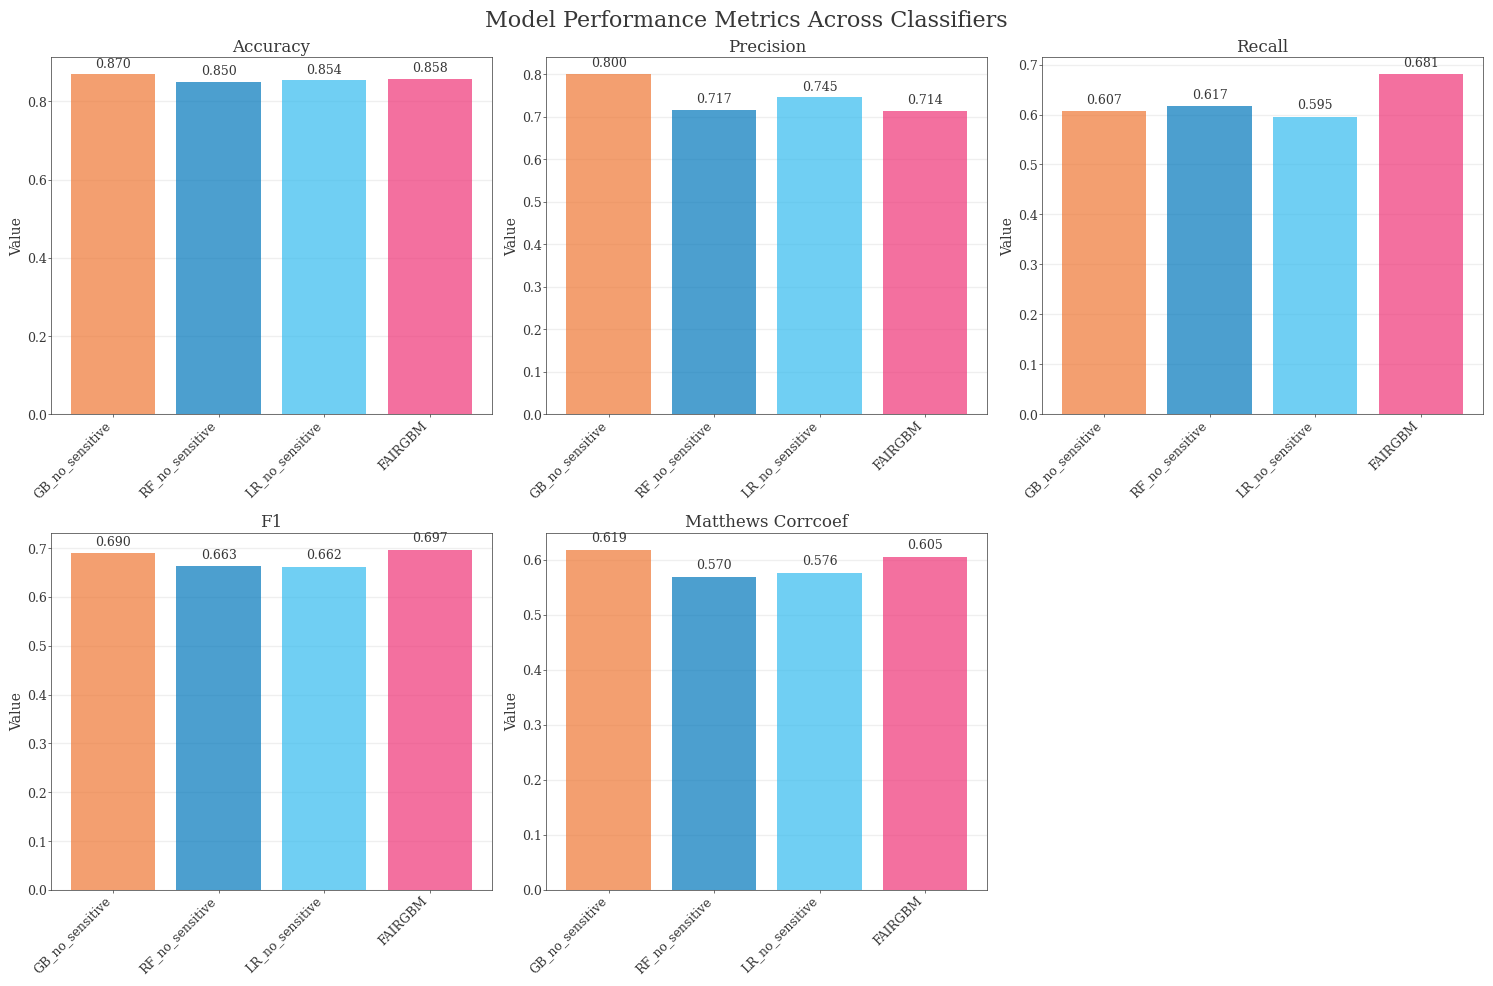

In [37]:
# Plot model performance metrics
fig, axes = plot_model_performance(
    performance_df, 
    save_path='./adult_charts/model_performance_metrics.pdf'
)


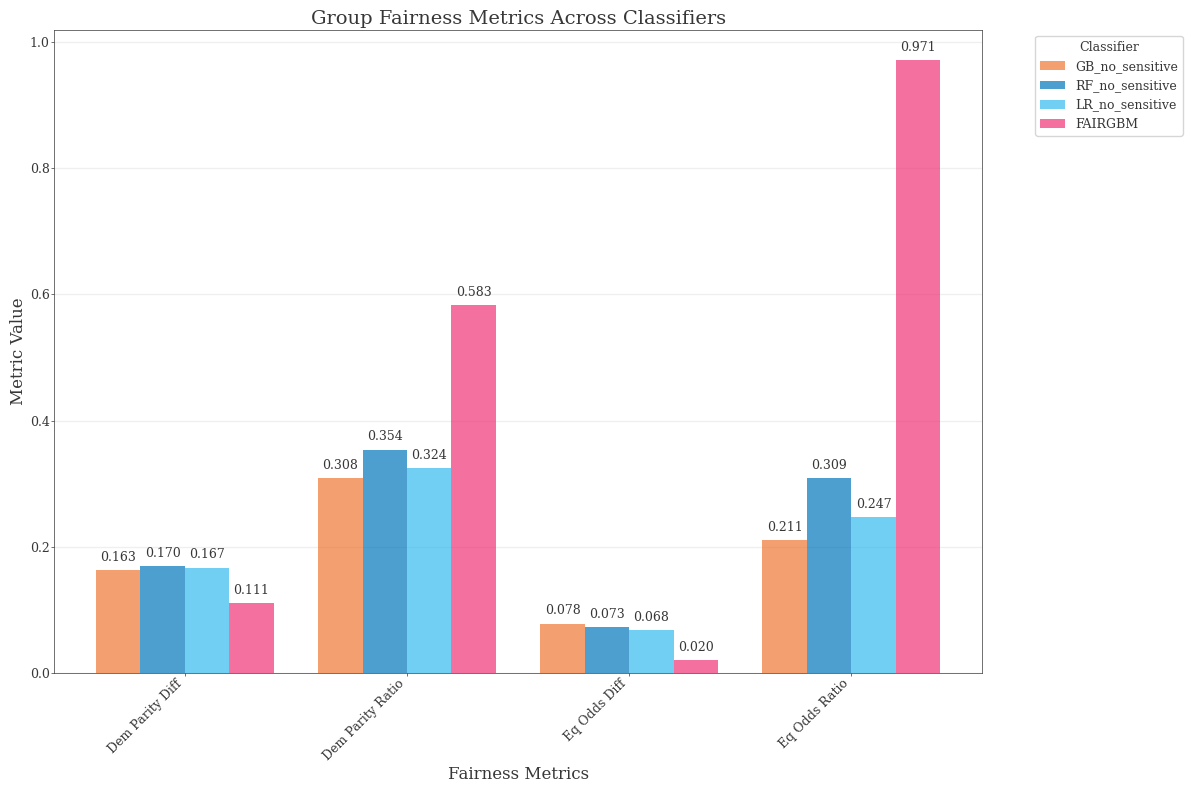

In [38]:
# Plot group fairness metrics
fig, ax = plot_group_fairness(
    fairness_df, 
    save_path='./adult_charts/group_fairness_metrics.pdf'
)


In [39]:
# Summary statistics for model performance
print("Model Performance Summary:")
print("=" * 50)
performance_summary = performance_df.pivot(index='metric', columns='classifier', values='value')
print(performance_summary.round(4))

print("\n" + "=" * 50)
print("Group Fairness Summary:")
print("=" * 50)
fairness_summary = fairness_df.pivot(index='metric', columns='classifier', values='value')
print(fairness_summary.round(4))


Model Performance Summary:
classifier           FAIRGBM  GB_no_sensitive  LR_no_sensitive  \
metric                                                           
accuracy              0.8582           0.8696           0.8544   
f1                    0.6969           0.6900           0.6619   
false_negative_rate   0.3191           0.3935           0.4046   
false_positive_rate   0.0860           0.0476           0.0641   
matthews_corrcoef     0.6047           0.6188           0.5765   
precision             0.7136           0.8002           0.7452   
recall                0.6809           0.6065           0.5954   
selection_rate        0.2284           0.1814           0.1912   
true_negative_rate    0.9140           0.9524           0.9359   
true_positive_rate    0.6809           0.6065           0.5954   

classifier           RF_no_sensitive  
metric                                
accuracy                      0.8499  
f1                            0.6630  
false_negative_rate     